This code is written to generate synthetic data to learn a ROM for a chaotic 1D fault earthquake sequence.

Steps:
* import functions.
* apply/load POD.


    1- To apply the POD, you can apply it seperately on v and theta or you can apply it all together

    
* randomly sample initial condition.
* save the output.


In [1]:
import numpy as np
import cte_eq
import sys
sys.path.append('./..')
import cte
import matplotlib.pyplot as plt
from ProcessFunctions import Ploteigs,ApplyPODStateSpace2D,GenRandom_ai,FindInitFromAi
from Forward2d import forwardmodel

In [3]:
index=0
np.random.seed(index)  # seed is set using the index

In [5]:
# load the long simulation.
drs=0.012
T_final_load=10500
ApplyPOD=True # 1 if you want to apply POD, 0 if you want to load the data
Nxout=cte_eq.Nxout
Ntout=cte_eq.Ntout
T_filter=500 




In [6]:
if ApplyPOD:
    direct='/central/groups/astuart/hkaveh/Data/LearnROM/transfer/2DSim_MainSimulation_Tf'+str(T_final_load)+"Nx="+str(Nxout)+"Nt="+str(Ntout)+'drs'+str(drs)+".npz"
    data=np.load(direct)
    v=data['v']
    theta=data['theta']
    dc=data['dc']
    t=data['t']
    Nx=dc.shape[0]
    U,S,VT,q_bar=ApplyPODStateSpace2D(v,theta,t,T_filter,Nx)
    # saving U,S,VT,q_bar to later use in if ApplyPOD==0
    np.savez('/central/groups/astuart/hkaveh/Data/LearnROM/transfer/'+str(T_final_load)+"Nx="+str(Nxout)+"Nt="+str(Ntout)+'drs'+str(drs),U=U,S=S,VT=VT,q_bar=q_bar)
else:
    # load U,S,VT,q_bar
    data=np.load('/central/groups/astuart/hkaveh/Data/LearnROM/transfer/'+str(T_final_load)+"Nx="+str(Nxout)+"Nt="+str(Ntout)+'drs'+str(drs)+'.npz')
    U=data['U']
    S=data['S']
    VT=data['VT']
    q_bar=data['q_bar']
    



KeyboardInterrupt: 

: 

In [5]:
Nt2=VT.shape[0] # number of snapshots in the dataset after filtering first T_filter years
Nx=U.shape[0]//2

In [6]:
N_m=30
coeff=1
Specifyinit=True
T_final_run=350 # The interevent time is 34 years, how many events you want to include? I think 10 events is good
ai=GenRandom_ai(U,S,N_m,Nt2,coeff)
print(ai)
u_init=FindInitFromAi(ai,U,N_m,q_bar)
print(u_init.shape)
v0=10**(u_init[:Nx])
v0max=np.max(v0)
while v0max>1e2: # making sure the initial condition is somewhere that has less than 1e3 maximum slip rate
    ai=GenRandom_ai(U,S,N_m,Nt2,coeff)
    u_init=FindInitFromAi(ai,U,N_m,q_bar)
    v0=10**(u_init[:Nx])
    print(u_init[0])
    v0=10**(u_init[:Nx])
    v0max=np.max(v0)

[[-4.63880238e+02 -7.61108028e+01 -7.53083525e+01 -7.94375238e+01
  -7.86596248e+01  3.90116391e+01  4.75745304e+01  4.53659020e+01
  -2.45468480e+01  2.11380365e+01  1.34243319e+00 -2.82911356e+01
  -1.40231309e+01 -3.36719824e+00  8.40181754e+00  5.96615397e+00
  -1.43512020e+01  1.08096849e+00  2.76766569e-01  1.81622814e+01
   1.53139601e+01 -4.17074097e+00  6.70580893e-01  2.54553261e+00
  -4.17853415e+00  5.93515961e+00 -1.41362150e+01  9.83915766e+00
   2.78095945e+00 -1.49572031e+01]]
(8192, 1)
[-8.49332184]


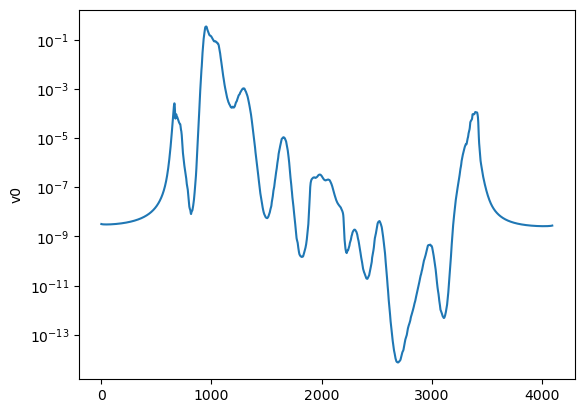

In [7]:
plt.plot(10**(u_init[:Nx]))
plt.yscale("log")
plt.ylabel('v0')
plt.savefig('v0.png')

In [8]:
p=forwardmodel(T_final_run,cte_eq.Ntout,cte_eq.Nxout,Specifyinit,u_init,drs)

Number of elements 4096
 Number of processors =            1
 Start reading input ...
    Mesh input complete
   Flags input complete
 Input complete
 Initializing mesh ...
 1D fault, uniform grid
 Impedance =    4545454.5454545459     
 Intializing kernel: ...
 FFT applied
 Reading kernel /central/groups/astuart/hkaveh/QDYN/qdyn-read-only/src/kernel_I.tab
 Kernel intialized
 Values at selected point of the fault:
 K/Kc =   -4.7123889803846894E-002
 K/Kb =    1.1780972450961723E-002

     it,  dt (secs), time (yrs), v_max (m/s), sigma_max (MPa)
 Initialising RK45 solver
 Finished initialising RK45 solver
 Initialization completed
      0   0.000E+00   0.000E+00   0.354E+00   0.500E+02


KeyboardInterrupt: 

In [ ]:
direct='./Data/SampleSimulation_Tf_2D'+str(T_final_run)+"Nt="+str(cte_eq.Ntout)+"N_m"+str(N_m)+"coeff"+str(coeff)+"number"+str(index)
# You only need time, V, theta, so only saving those:
x_ox=p.ox["x"].unique()
Nt=len(p.ox["v"])//(len(x_ox)) # Number of Snapshots
t_ox=p.ox["t"].values.reshape((Nt,len(x_ox)))
V_ox=p.ox["v"].values.reshape((Nt,len(x_ox)))
theta_ox=p.ox["theta"].values.reshape((Nt,len(x_ox)))
np.savez_compressed(direct+'.npz', array1=V_ox, array2=theta_ox, array3=t_ox)


FileNotFoundError: [Errno 2] No such file or directory: './Data/SampleSimulation_Tf_2D350Nt=1500N_m30coeff1number35.npz'